In [19]:
import os
import json
import ase
from glob import glob
from ase import Atoms
from tqdm import tqdm
import numpy as np
from collections import defaultdict

import torch

from atomdiff.models.prior import LitScoreNet
from atomdiff.models.forward import LitDOSNet
from atomdiff.datasets import *

from graphite.nn import periodic_radius_graph

from matplotlib import pyplot as plt

In [3]:
data_module = StructureDataModule(
    data_dir='/net/csefiles/coc-fung-cluster/Shuyi/Datasets/dos/mp_dos_20_train_17386.json',
    cutoff=5.0,
    train_prior=True,
    k=0.8,
    train_size=0.9,
    scale_y=1.0,
    dup=1,
    batch_size=8,
    num_workers=4
)

score_net = LitScoreNet.load_from_checkpoint(
    './training_logs/mp-dos-20-17386-dup1/version_1/checkpoints/epoch=999-step=544000.ckpt'
)

data_module.setup()
diffuser = data_module.train_set.diffuser

Getting PyG Data objects...


100%|██████████| 17386/17386 [00:01<00:00, 17132.89it/s]


In [4]:
forward_model = LitDOSNet.load_from_checkpoint(
    "./training_logs/dos_net/version_2/checkpoints/epoch=183-step=200000.ckpt"
)

In [8]:
from torch import nn

def prior_score(z, pos, cell, t, cutoff=data_module.cutoff):
    edge_index, edge_vec = periodic_radius_graph(pos, cutoff, cell)
    edge_len  = edge_vec.norm(dim=-1, keepdim=True)
    edge_attr = torch.hstack([edge_vec, edge_len])
    return score_net.ema_model(z, edge_index, edge_attr, t, diffuser.sigma(t))

class LikelihoodScore_Chung(nn.Module):
    def __init__(self, score_model, forward_model, y, rho=1.0):
        super().__init__()
        self.score_model = score_model
        self.forward_model = forward_model
        self.y = y
        self.rho = rho

    def forward(self, z, pos, cell, t, cutoff=3.0):
        with torch.enable_grad():
            # Prepare for autograd
            pos.detach()
            pos.requires_grad = True

            _z = z.clone().detach()

            # Convert to graph
            edge_index, edge_vec = periodic_radius_graph(pos, cutoff, cell)
            edge_attr = torch.hstack([edge_vec, edge_vec.norm(dim=-1, keepdim=True)])

            # Estimate clean pos
            sigma = diffuser.sigma(t)
            score = self.score_model(z, edge_index, edge_attr, t, sigma)
            est_clean_pos = pos + sigma.pow(2)*score

            assert torch.allclose(z, _z)

            # Convert to graph again
            edge_index, edge_vec = periodic_radius_graph(pos, cutoff, cell)
            edge_attr = torch.hstack([edge_vec, edge_vec.norm(dim=-1, keepdim=True)])

            # Compute likelihood score
            pred_y = self.forward_model(z, edge_index, edge_attr)
            norm = torch.linalg.norm(self.y - pred_y, dim=1, keepdim=True)
            grad = torch.autograd.grad([norm.square().mean()], pos)[0]

            assert torch.allclose(z, _z)
        return - (self.rho / norm) * grad, norm
    
class ConditionalScore(nn.Module):
    def __init__(self, prior_score_fn, likelihood_score_fn):
        super().__init__()
        self.prior_score_fn = prior_score_fn
        self.likelihood_score_fn = likelihood_score_fn
    
    def forward(self, z, pos, cell, t):
        p_score = self.prior_score_fn(z, pos, cell, t)
        l_score, norm = self.likelihood_score_fn(z, pos, cell, t)
        # print(f'p-score norm: {p_score.norm().item():.3f}, l-score norm: {l_score.norm().item():.3f}, tgt norm: {norm.mean().item():.4f}')
        return p_score + l_score

# def cond_score(z, pos, cell, t):
#     p_score = prior_score(z, pos, cell, t)
#     l_score, norm = LikelihoodScore_Chung._forward(z, pos, cell, t)
#     print(f'p-score norm: {p_score.norm().item():.3f}, l-score norm: {l_score.norm().item():.3f}, tgt norm: {norm.mean().item():.4f}')
#     return p_score + l_score

def denoise_by_sde(z, pos, cell, score_fn, ts=torch.linspace(0.999, 0.001, 128+1)):
    ts = ts.to(pos.device).view(-1, 1)
    pos_traj = [pos.clone()]
    f, g, g2 = diffuser.f, diffuser.g, diffuser.g2
    for i, t in enumerate(ts[1:]):
        dt = ts[i+1] - ts[i]
        eps = dt.abs().sqrt() * torch.randn_like(pos)
        score = score_fn(z, pos, cell, t)
        disp = (f(t)*pos - g2(t)*score)*dt + g(t)*eps
        pos += disp
        pos_traj.append(pos.clone())
    return torch.stack(pos_traj)

In [39]:
device = 'cuda'
forward_model = forward_model.to(device)
score_net = score_net.to(device)

train_data_path = "/net/csefiles/coc-fung-cluster/Shuyi/Datasets/dos/mp_dos_20_train_17386.json"
f = open(train_data_path, 'r')
train_data = json.load(f)
f.close()

val_data_path = "/net/csefiles/coc-fung-cluster/Shuyi/Datasets/dos/mp_dos_20_val_5910.json"
f = open(val_data_path, 'r')
val_data = json.load(f)
f.close()

In [22]:
def get_target(data):
    atoms = ase.Atoms(
        numbers=data['atomic_numbers'],
        positions=data['positions'],
        cell=data['cell'],
        pbc=[True] * 3
    )

    pos = torch.tensor(atoms.positions, dtype=torch.float, device=device)
    cell = torch.tensor(atoms.cell.array, dtype=torch.float, device=device)
    atomic_numbers = atoms.numbers

    # target
    target_y = torch.tensor(data['y'], dtype=torch.float, device=device)

    # initialize z 
    z = torch.tensor(atoms.numbers, device=device)
    z = data_module.train_set.atom_encoder(z)
    z = z.float()

    # Convert to graph 
    cutoff = 6.0
    edge_index, edge_vec = periodic_radius_graph(pos, cutoff, cell)
    edge_attr = torch.hstack([edge_vec, edge_vec.norm(dim=-1, keepdim=True)])

    # Compute predicted y
    pred_y = forward_model.ema_model(z, edge_index, edge_attr)

    pred_y = pred_y.mean(axis=0, keepdims=True)
    target_y = target_y.mean(axis=0, keepdims=True)

    return pred_y, target_y

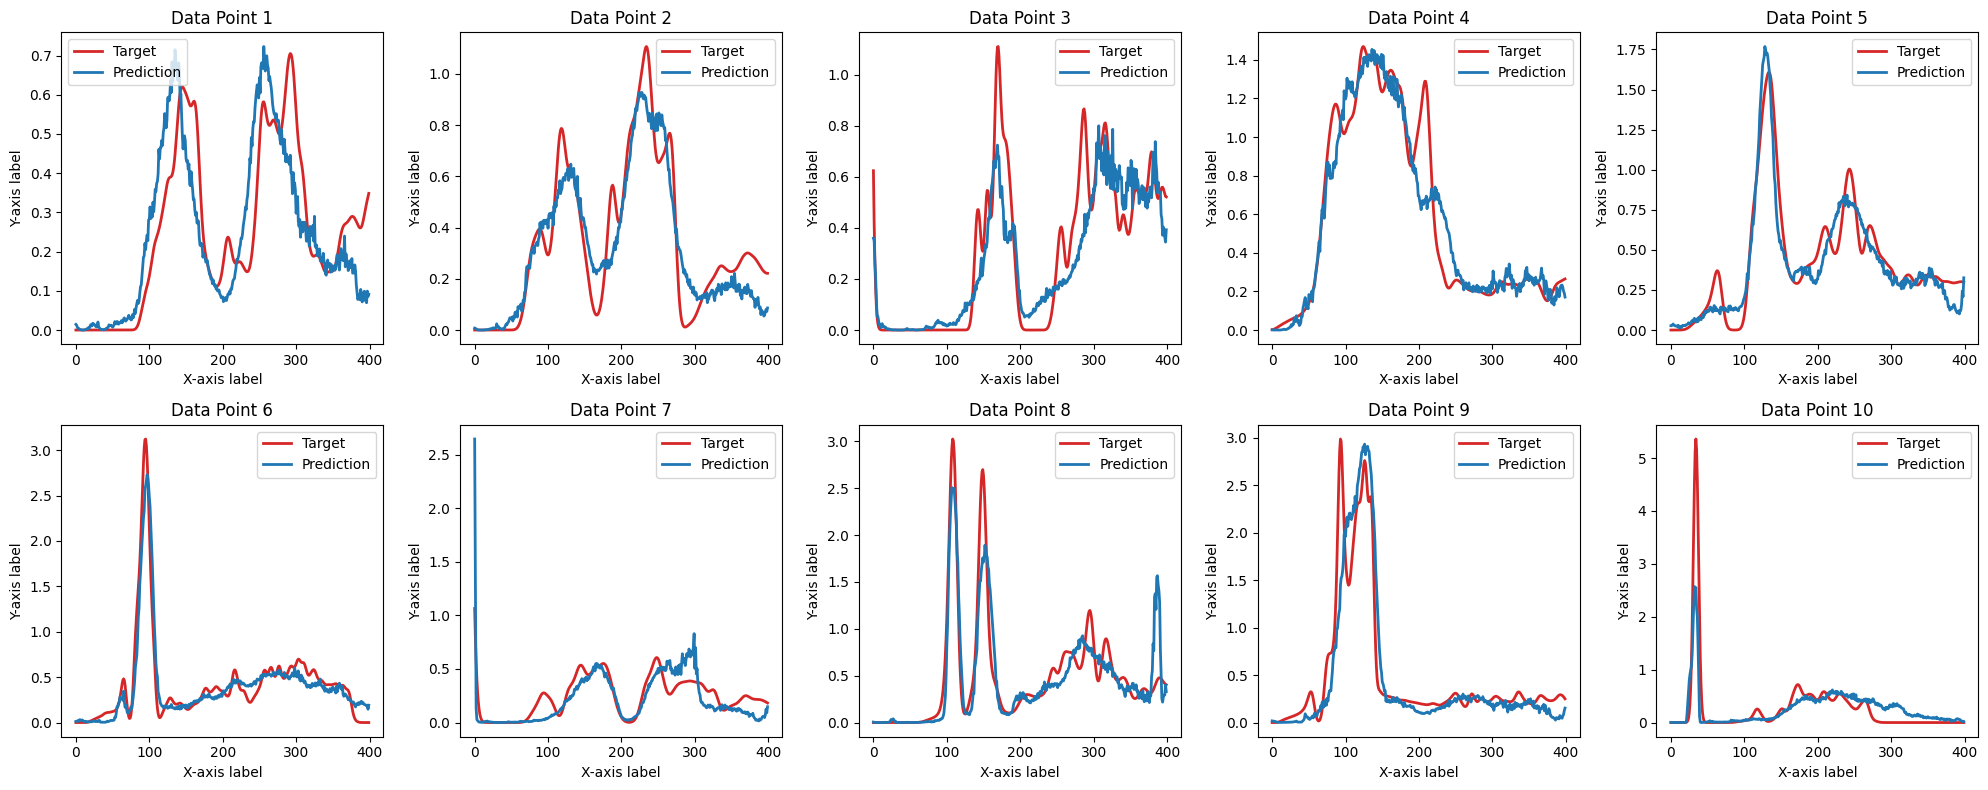

In [40]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i in range(10):
    pred_y, target_y = get_target(val_data[i])
    axes[i].plot(target_y.squeeze().cpu(), linewidth=2, color='tab:red', label='Target')
    axes[i].plot(pred_y.detach().squeeze().cpu(), linewidth=2, color='tab:blue', label='Prediction')
    axes[i].set_xlabel('X-axis label')
    axes[i].set_ylabel('Y-axis label')
    axes[i].set_title(f'Data Point {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()

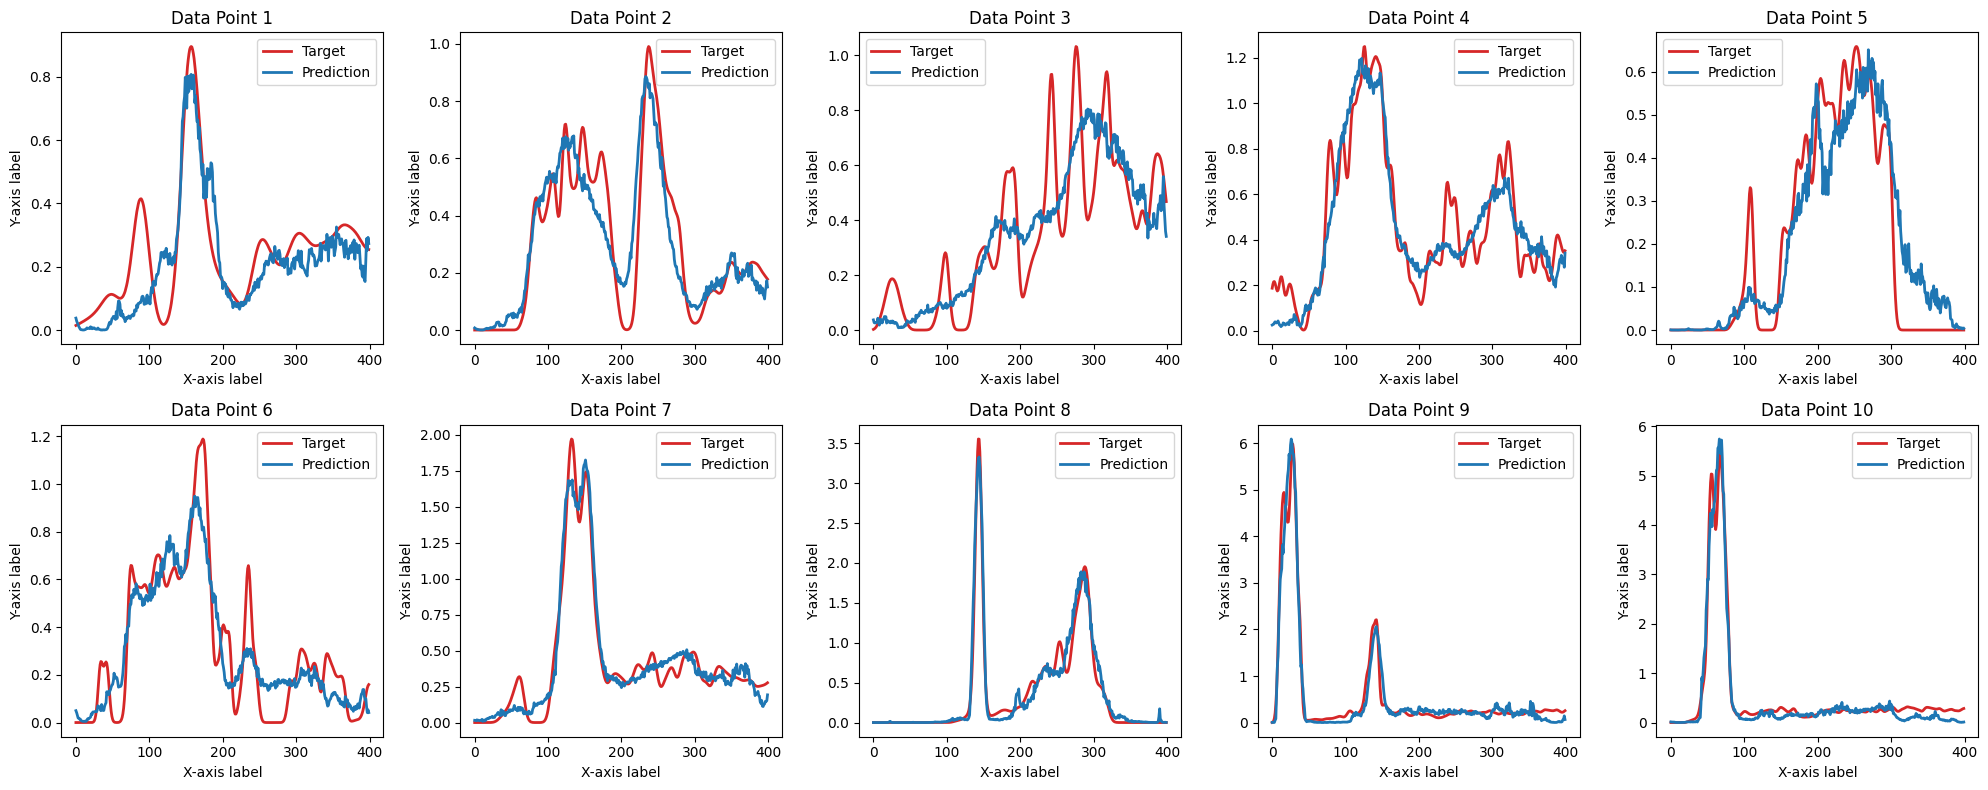

In [41]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i in range(10):
    pred_y, target_y = get_target(train_data[i])
    axes[i].plot(target_y.squeeze().cpu(), linewidth=2, color='tab:red', label='Target')
    axes[i].plot(pred_y.detach().squeeze().cpu(), linewidth=2, color='tab:blue', label='Prediction')
    axes[i].set_xlabel('X-axis label')
    axes[i].set_ylabel('Y-axis label')
    axes[i].set_title(f'Data Point {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()